In [1]:
path = 'c_normal.csv'
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv(path)
df1.head(20)


Timestamp    Ax    Ay    Az      Gx      Gy      Gz
0   14:43:09.960159  0.53  3.23  3.23  -53.99   68.32  160.06
1   14:43:10.045730  0.47  1.68  1.68  -55.58  135.82  262.35
2   14:43:10.152684  0.25  1.80  1.80 -116.49  184.88  415.70
3   14:43:10.255015  0.25  2.04  2.04 -105.30  806.95  786.25
4   14:43:10.357418  0.65  0.66  0.66  478.17  645.12  154.36
5   14:43:10.464667  0.64  1.18  1.18  737.99  137.07 -791.55
6   14:43:10.570979  0.05  1.59  1.59  510.12  133.99 -999.02
7   14:43:10.673485  0.32  1.87  1.87  -54.73 -104.30  332.90
8   14:43:10.775492  2.27  1.29  1.29   51.34  -35.03  455.46
9   14:43:10.881785  1.01  1.70  1.70  -33.26  -39.42  243.05
10  14:43:10.983574  0.42  1.62  1.62  -63.35   -1.07  149.21
11  14:43:11.086315  0.47  1.59  1.59  -59.79   50.61  195.21
12  14:43:11.193005  0.28  1.79  1.79 -108.38  100.30  275.49
13  14:43:11.299341 -0.26  2.15  2.15 -243.93   49.18  488.23
14  14:43:11.402660  0.85  1.46  1.46  -93.87  563.41  423.26
15  14:43:11.504297  0.76  0.91  0.91  309.82  215.91 -387.80
16  14:43:11.610650  1.33  1.53  1.53  521.71  -91.92 -952.93
17  14:43:11.717535 -0.06  1.75  1.75  616.10  -65.12 -781.01
18  14:43:11.815383  0.46  1.71  1.71   13.84    8.35  330.91
19  14:43:11.921854  2.10  1.48  1.48  -19.05 -402.87  531.52

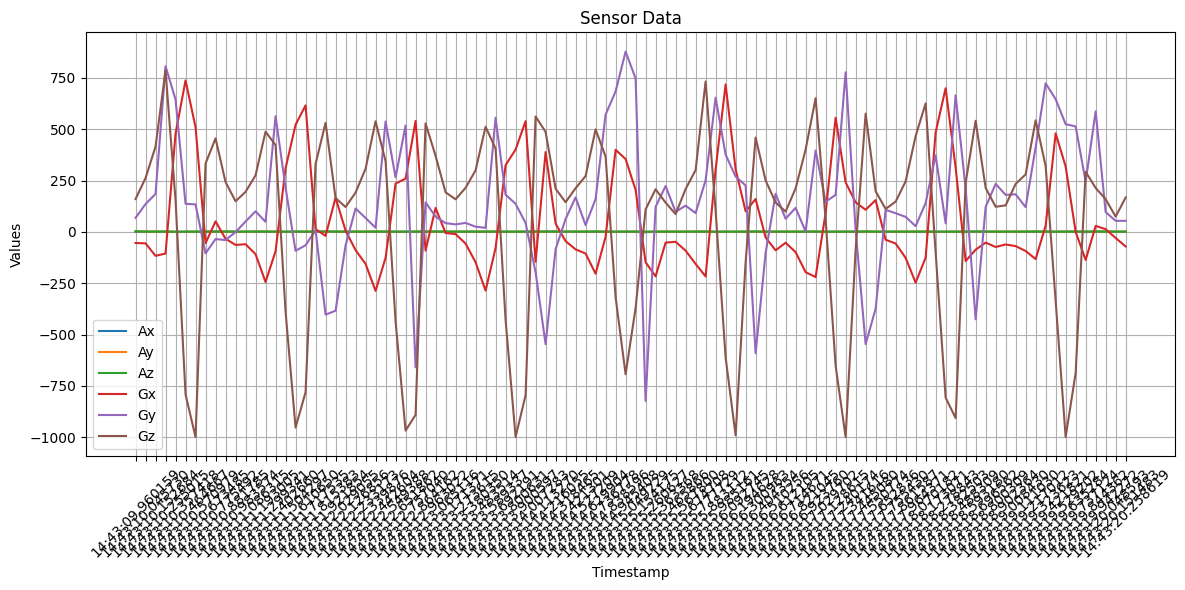

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
path = 'c_normal.csv'
df1 = pd.read_csv(path)
df=df1.iloc[:100]
# Plotting
plt.figure(figsize=(12, 6))

for col in df.columns[1:]:
    plt.plot(df['Timestamp'], df[col], label=col)

plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Sensor Data')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
!pip install tensorflow

^C


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
# Read data from CSV files and create sequences
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

scaler = MinMaxScaler()

def read_and_create_sequences(paths, look_back):
    all_X, all_Y = [], []
    for path in paths:
        df = pd.read_csv(path)
        # Drop rows with infinity or extremely large values
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        # Select required columns
        df = df[['Gx','Gy','Gz']]
        
        # Remove outliers using Interquartile Range (IQR)
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
        
        if len(df) == 0:  # Check if DataFrame is empty after outlier removal
            print(f"Empty DataFrame after outlier removal for file: {path}")
            continue  # Skip processing this file
        
        # Normalize the data
        normalized_data = scaler.fit_transform(df)
        # Convert the data into sequences
        X, Y = [], []
        for i in range(len(normalized_data) - look_back - 1):
            X.append(normalized_data[i:(i + look_back), :])
            Y.append(normalized_data[i + look_back, :])
        all_X.append(X)
        all_Y.append(Y)
    return np.concatenate(all_X), np.concatenate(all_Y)

# Define paths for training and test data
train_paths = ['c_normal.csv','c_abnormal.csv']
test_paths=['ct_normal.csv','ct_abnormal.csv']
# Define the look back for creating sequences
look_back = 30

# Read and create sequences for training data
trainX, trainY = read_and_create_sequences(train_paths, look_back)

# Read and create sequences for test data
testX, testY = read_and_create_sequences(test_paths, look_back)

# Display shapes of train and test data
print(f"Shape Of TrainX: {trainX.shape}")
print(f"Shape Of TrainY: {trainY.shape}")
print(f"Shape Of TestX: {testX.shape}")
print(f"Shape Of TestY: {testY.shape}")

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(look_back, 3), return_sequences=False))
model.add(Dense(3))  # Adjust output size to match the number of features
model.compile(loss='mean_squared_error', optimizer='adam')

# Define early stopping and model checkpoint
# early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1)

model.fit(trainX, trainY, epochs=500, batch_size=10, verbose=2, validation_split=0.05)

# Make predictions
trainPredict = model.predict(trainX)

# Invert predictions and targets to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

train_rmse = sqrt(mean_squared_error(trainY, trainPredict))
train_r2 = r2_score(trainY, trainPredict)

print('Train RMSE: %.3f' % train_rmse)
print('Train R2 score: %.3f' % train_r2)

# # Make predictions
testPredict = model.predict(testX)

# Invert predictions and targets to original scale
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

test_rmse = sqrt(mean_squared_error(testY, testPredict))
test_r2 = r2_score(testY, testPredict)

print('test RMSE: %.3f' % test_rmse)
print('test R2 score: %.3f' % test_r2)


Shape Of TrainX: (2964, 30, 3)
Shape Of TrainY: (2964, 3)
Shape Of TestX: (724, 30, 3)
Shape Of TestY: (724, 3)
Epoch 1/500


c:\Users\Shubham Kumar Jha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


282/282 - 5s - 19ms/step - loss: 0.0407 - val_loss: 0.0211
Epoch 2/500
282/282 - 2s - 8ms/step - loss: 0.0331 - val_loss: 0.0181
Epoch 3/500
282/282 - 2s - 7ms/step - loss: 0.0296 - val_loss: 0.0168
Epoch 4/500
282/282 - 2s - 8ms/step - loss: 0.0278 - val_loss: 0.0153
Epoch 5/500
282/282 - 2s - 7ms/step - loss: 0.0271 - val_loss: 0.0155
Epoch 6/500
282/282 - 2s - 8ms/step - loss: 0.0265 - val_loss: 0.0174
Epoch 7/500
282/282 - 2s - 7ms/step - loss: 0.0256 - val_loss: 0.0184
Epoch 8/500
282/282 - 2s - 9ms/step - loss: 0.0250 - val_loss: 0.0152
Epoch 9/500
282/282 - 2s - 8ms/step - loss: 0.0243 - val_loss: 0.0158
Epoch 10/500
282/282 - 2s - 9ms/step - loss: 0.0240 - val_loss: 0.0172
Epoch 11/500
282/282 - 2s - 8ms/step - loss: 0.0235 - val_loss: 0.0173
Epoch 12/500
282/282 - 2s - 7ms/step - loss: 0.0231 - val_loss: 0.0170
Epoch 13/500
282/282 - 2s - 7ms/step - loss: 0.0230 - val_loss: 0.0160
Epoch 14/500
282/282 - 2s - 7ms/step - loss: 0.0226 - val_loss: 0.0151
Epoch 15/500
282/282 - 2s 

ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    unknown package:
        Expected sha256 a2aed5f5f7a9e22bcedd843d7bc3595eaf75510662f8f3d113ee3223fefed16a
             Got        521a520659a61406f8eeb4e3937b7549b166b9c5095a3baec8c687a143ed7846




   ------ --------------------------------- 62.6/376.9 MB 42.8 kB/s eta 2:02:17
   ------ --------------------------------- 62.6/376.9 MB 42.8 kB/s eta 2:02:17
   ------ --------------------------------- 62.6/376.9 MB 42.8 kB/s eta 2:02:17
   ------ --------------------------------- 62.6/376.9 MB 42.8 kB/s eta 2:02:17
   ------ --------------------------------- 62.6/376.9 MB 42.7 kB/s eta 2:02:40
   ------ --------------------------------- 62.6/376.9 MB 42.7 kB/s eta 2:02:40
   ------ --------------------------------- 62.6/376.9 MB 42.7 kB/s eta 2:02:40
   ------ --------------------------------- 62.6/376.9 MB 42.7 kB/s eta 2:02:40
   ------ --------------------------------- 62.6/376.9 MB 42.7 kB/s eta 2:02:40
   ------ --------------------------------- 62.6/376.9 MB 42.7 kB/s eta 2:02:40
   ------ --------------------------------- 62.6/376.9 MB 42.7 kB/s eta 2:02:40
   ------ --------------------------------- 62.6/376.9 MB 42.7 kB/s eta 2:02:40
   ------ -----------------------------

ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    unknown package:
        Expected sha256 a2aed5f5f7a9e22bcedd843d7bc3595eaf75510662f8f3d113ee3223fefed16a
             Got        31e838fd1067a4b9190d3f4be0ff609cd03c3651af3ee896b157f9616c5a9dcc




   -------- ------------------------------ 84.5/376.9 MB 104.8 kB/s eta 0:46:30
   -------- ------------------------------ 84.5/376.9 MB 104.8 kB/s eta 0:46:30
   -------- ------------------------------ 84.5/376.9 MB 105.0 kB/s eta 0:46:25
   -------- ------------------------------ 84.5/376.9 MB 105.0 kB/s eta 0:46:25
   -------- ------------------------------ 84.5/376.9 MB 105.0 kB/s eta 0:46:25
   -------- ------------------------------ 84.5/376.9 MB 105.2 kB/s eta 0:46:20
   -------- ------------------------------ 84.5/376.9 MB 105.2 kB/s eta 0:46:20
   -------- ------------------------------ 84.5/376.9 MB 105.2 kB/s eta 0:46:20
   -------- ------------------------------ 84.6/376.9 MB 105.0 kB/s eta 0:46:26
   -------- ------------------------------ 84.6/376.9 MB 105.0 kB/s eta 0:46:26
   -------- ------------------------------ 84.6/376.9 MB 105.0 kB/s eta 0:46:26
   -------- ------------------------------ 84.6/376.9 MB 105.5 kB/s eta 0:46:13
   -------- ---------------------------

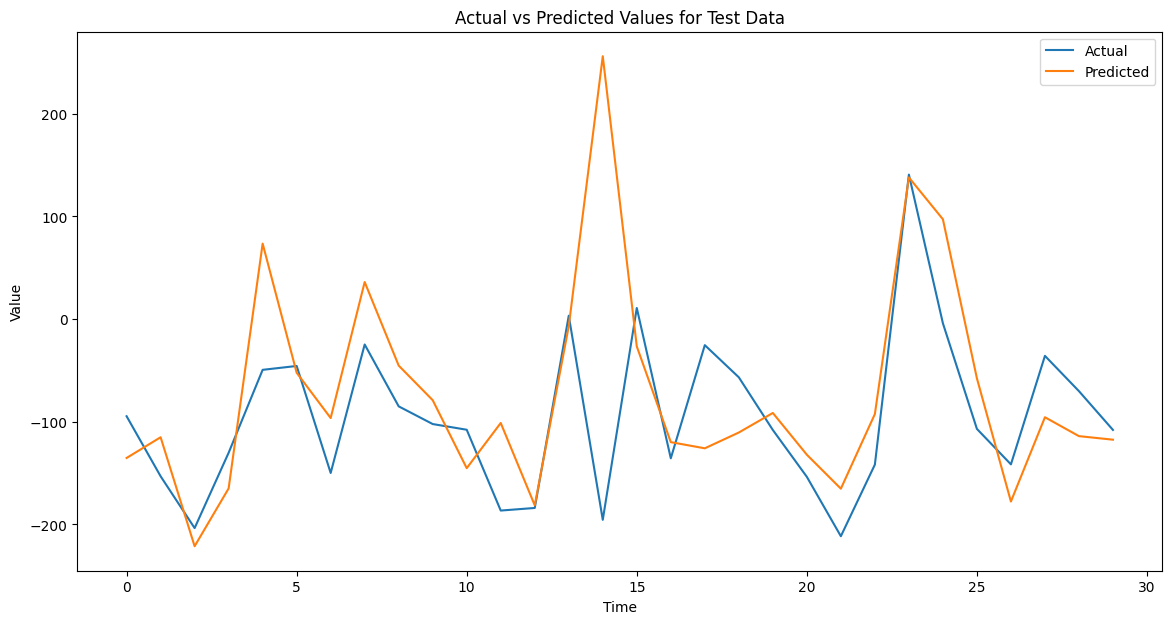

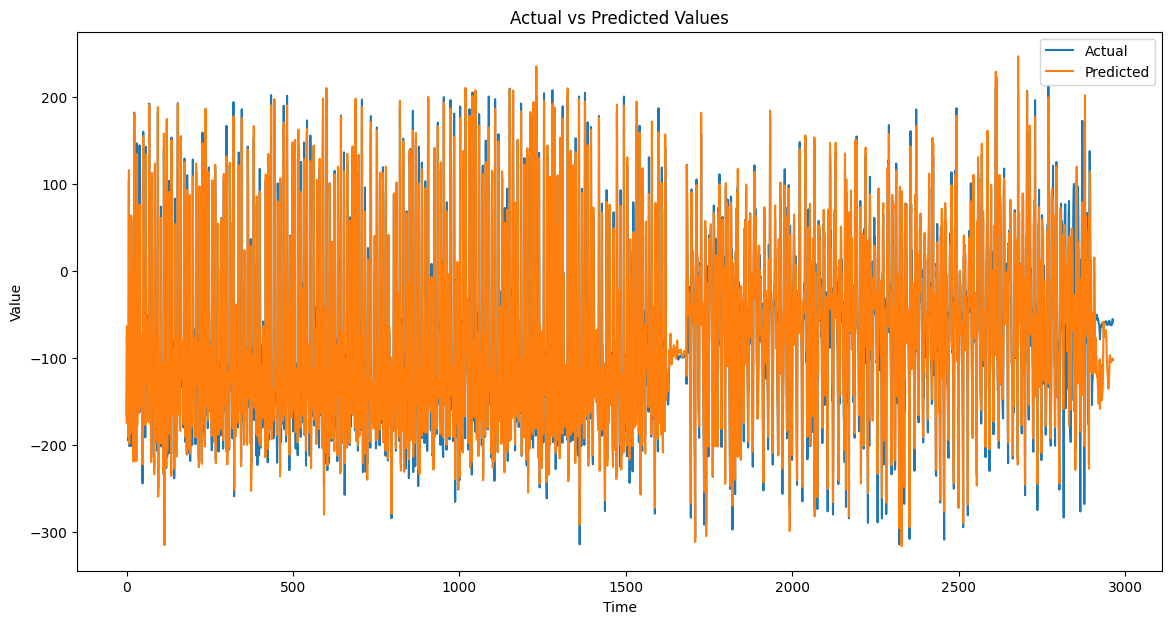

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

dfp = pd.DataFrame({'Actual': testY[:30, 0], 'Predicted': testPredict[:30, 0]})
plt.figure(figsize=(14, 7))
plt.plot(dfp['Actual'], label='Actual')
plt.plot(dfp['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Values for Test Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

import matplotlib.pyplot as plt
dfp = pd.DataFrame({'Actual': trainY[:, 0], 'Predicted': trainPredict[:, 0]})
plt.figure(figsize=(14, 7))
plt.plot(dfp['Actual'], label='Actual')
plt.plot(dfp['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
# Read data from CSV files and create sequences
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

scaler = MinMaxScaler()

def read_and_create_sequences(paths, look_back):
    all_X, all_Y = [], []
    for path in paths:
        df = pd.read_csv(path)
        # Drop rows with infinity or extremely large values
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        # Select required columns
        df = df[['Ax','Ay','Gx','Gy','Gz']]
        
        # Remove outliers using Interquartile Range (IQR)
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
        
        if len(df) == 0:  # Check if DataFrame is empty after outlier removal
            print(f"Empty DataFrame after outlier removal for file: {path}")
            continue  # Skip processing this file
        
        # Normalize the data
        normalized_data = scaler.fit_transform(df)
        # Convert the data into sequences
        X, Y = [], []
        for i in range(len(normalized_data) - look_back - 1):
            X.append(normalized_data[i:(i + look_back), :])
            Y.append(normalized_data[i + look_back, :])
        all_X.append(X)
        all_Y.append(Y)
    return np.concatenate(all_X), np.concatenate(all_Y)

# Define paths for training and test data
train_paths = ['c_normal.csv','c_abnormal.csv']
test_paths=['ct_normal.csv','ct_abnormal.csv']
# Define the look back for creating sequences
look_back = 30

# Read and create sequences for training data
trainX, trainY = read_and_create_sequences(train_paths, look_back)

# Read and create sequences for test data
testX, testY = read_and_create_sequences(test_paths, look_back)

# Display shapes of train and test data
print(f"Shape Of TrainX: {trainX.shape}")
print(f"Shape Of TrainY: {trainY.shape}")
print(f"Shape Of TestX: {testX.shape}")
print(f"Shape Of TestY: {testY.shape}")


# Define the model
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 5), return_sequences=False))
model.add(Dense(5))  # Adjust output size to match the number of features

model.compile(loss='mean_squared_error', optimizer='adam')

# Define early stopping and model checkpoint
# early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1)

# Define the checkpoint to save the best model weights
# checkpoint = ModelCheckpoint('best_model_weights.keras', monitor='loss', save_best_only=True, mode='min', verbose=2)

# Train the model with your data and use callbacks to store history and save best weights
# history = 
model.fit(trainX, trainY, epochs=481, batch_size=10, verbose=2, validation_split=0.1)

# # Get the best weights by loading the saved weights
# model.load_weights('best_model_weights.keras')

# Make predictions
trainPredict = model.predict(trainX)

# Invert predictions and targets to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

train_rmse = sqrt(mean_squared_error(trainY, trainPredict))
train_r2 = r2_score(trainY, trainPredict)

print('Train RMSE: %.3f' % train_rmse)
print('Train R2 score: %.3f' % train_r2)

# # Make predictions
testPredict = model.predict(testX)

# Invert predictions and targets to original scale
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

test_rmse = sqrt(mean_squared_error(testY, testPredict))
test_r2 = r2_score(testY, testPredict)

print('test RMSE: %.3f' % test_rmse)
print('test R2 score: %.3f' % test_r2)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001837A257F70>>
Traceback (most recent call last):
  File "c:\Users\chand\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
